In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sys import stdout
from time import sleep

from statsmodels.tsa.stattools import adfuller

from sklearn.feature_selection import f_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

import warnings
warnings.filterwarnings('ignore')

# DATA

In [2]:
train = pd.read_parquet('data/train.parquet')
test = pd.read_parquet('data/test.parquet')
sample_sub = pd.read_csv('data/sample_submission.csv')

train.head(10)

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
5,59504,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[0.08, 0.88, 1.46, 0.59, -0.97, -0.41, 0.78, -...",0.0
6,49554,"[2016-04-01, 2016-05-01, 2016-06-01, 2016-07-0...","[1.05, -0.28, 1.09, -0.69, 1.26, 1.79, 1.38, -...",0.0
7,58344,"[2016-12-01, 2017-01-01, 2017-02-01, 2017-03-0...","[-0.36, -0.45, -0.4, -0.4, -0.45, -0.45, -0.45...",0.0
8,87449,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.92, 4.11, 3.39, -1.17, -0.79, 2.15, -0.22, ...",1.0
9,43415,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-0.86, -0.05, -0.35, -0.67, -0.25, -0.8, -0.6...",1.0


In [3]:
sample_sub.head(10)

,id,score
0,6125.0,0.757097
1,26781.0,0.346173
2,13333.0,0.431305
3,53218.0,0.847472
4,84204.0,0.065298
5,69997.0,0.689232
6,99301.0,0.025703
7,4361.0,0.461261
8,46607.0,0.293316
9,29836.0,0.233549


Посмотрим, какого размера данные и есть ли в них пропуски

In [4]:
test['label'] = -1
data = pd.concat([train, test], ignore_index=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      100000 non-null  int64  
 1   dates   100000 non-null  object 
 2   values  100000 non-null  object 
 3   label   100000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


Пропусков не найдено, но есть интересная деталь. Поскольку столбцы с датами и значениями содержат массивы, то можно реструктурировать данные и встроить эти массивы в альтернативную таблицу, указав идентификатор и класс объекта на каждой временной отметке. Если взять только один объект, то это будет выглядеть примерно так.

In [5]:
pd.DataFrame({col: data.loc[0, col] for col in train.columns}) 

,id,dates,values,label
0,19114,2016-01-01,-1.86,0.0
1,19114,2016-02-01,0.79,0.0
2,19114,2016-03-01,1.40,0.0
3,19114,2016-04-01,0.15,0.0
4,19114,2016-05-01,0.00,0.0
...,...,...,...,...
57,19114,2020-10-01,-0.28,0.0
58,19114,2020-11-01,0.89,0.0
59,19114,2020-12-01,0.35,0.0
60,19114,2021-01-01,-0.51,0.0


Потом к этой таблице будут снизу присоединяться все новые значения, созданные таким же способом. Для этого я создал функцию.

In [10]:
def restructure_data(data):
    newdf = pd.DataFrame()
    
    print('Rows restructured:')
    for i in data.index: 
        row = pd.DataFrame({
            col: data.loc[i, col] 
            for col in data.columns
        })
        
        newdf = pd.concat([newdf, row], ignore_index=True)
        
        stdout.write(f"\r{i+1}")
        stdout.flush()
        sleep(0.00001)
    print('\n')
    
    dates = pd.to_datetime(newdf['dates'])
    
    newdf['year'] = dates.dt.year
    newdf['month'] = dates.dt.month
    newdf['quarter'] = dates.dt.quarter
    newdf['dayofweek'] = dates.dt.dayofweek

    newdf.drop('dates', axis=1, inplace=True)
    
    newdf.to_csv('data/restructured_data.csv', index=False)
    
    return newdf

In [11]:
%%time
restructure_data(data) 

Rows restructured:
100000

CPU times: total: 14min 5s
Wall time: 38min 41s


,id,values,label,year,month,quarter,dayofweek
0,19114,-1.86,0.0,2016,1,1,4
1,19114,0.79,0.0,2016,2,1,0
2,19114,1.40,0.0,2016,3,1,1
3,19114,0.15,0.0,2016,4,2,4
4,19114,0.00,0.0,2016,5,2,6
...,...,...,...,...,...,...,...
6442359,73528,-0.53,-1.0,2023,2,1,2
6442360,73528,1.65,-1.0,2023,3,1,2
6442361,73528,0.07,-1.0,2023,4,2,5
6442362,73528,0.62,-1.0,2023,5,2,0


Реструктуризация данных заняла около 40 минут и теперь таблица имеет более 6.4 млн строк! Лучше ее сохранить отдельно, чтобы потом долго не ждать, когда я вернусь к работе.

---

# PROCESSING & EDA

In [3]:
re_data = pd.read_csv('data/restructured_data.csv')

re_train = re_data[re_data['label'] >= 0]
re_test = re_data[re_data['label'] < 0].drop('label', axis=1)

re_train

,id,values,label,year,month,quarter,dayofweek
0,19114,-1.86000,0.0,2016,1,1,4
1,19114,0.79000,0.0,2016,2,1,0
2,19114,1.40000,0.0,2016,3,1,1
3,19114,0.15000,0.0,2016,4,2,4
4,19114,0.00000,0.0,2016,5,2,6
...,...,...,...,...,...,...,...
5155407,98870,1.40335,1.0,2019,11,4,4
5155408,98870,0.26335,1.0,2019,12,4,6
5155409,98870,-1.73665,1.0,2020,1,1,2
5155410,98870,-0.38665,1.0,2020,2,1,5


Отлично! Мы поделили данные обратно на обучающую и тестовую выборки. Теперь посмотрим, как они выглядят на графике, а заодно и проверим данные на "загрязненность".

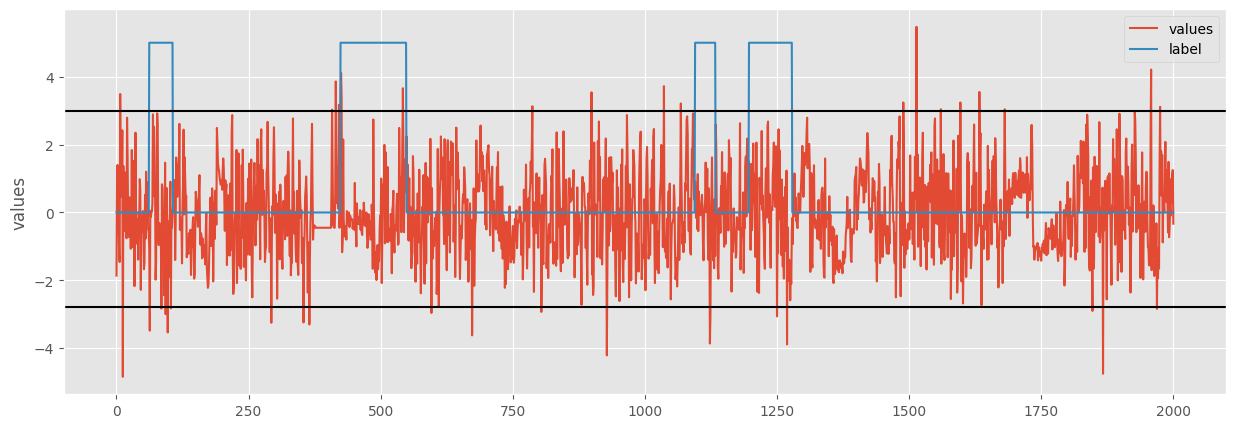

In [4]:
sns.lineplot(re_train.loc[:2000, 'values'], label='values')
sns.lineplot(re_train.loc[:2000, 'label']*5, label='label')

q_upper = re_train['values'].quantile(0.99)
q_lower = re_train['values'].quantile(0.01)

plt.axhline(q_upper, color='black')
plt.axhline(q_lower, color='black')

plt.show()

Как видим, значения очень "острые", а это ухудшает их корреляцию с целевым признаком и соответственно будет запутывать модель. Значит нужно удалить выбросы и провести экспоненциальное сглаживание, поэтапно подобрав ширину окна для этого.

In [5]:
n_outs = re_train[
    (re_train['values'] > q_upper) | 
    (re_train['values'] < q_lower)
    ].shape[0]

re_train = re_train[
    (re_train['values'] < q_upper) & 
    (re_train['values'] > q_lower)
    ].reset_index(drop=True)

print('Outliers removed:', n_outs)

Outliers removed: 102020


Best window value: 3


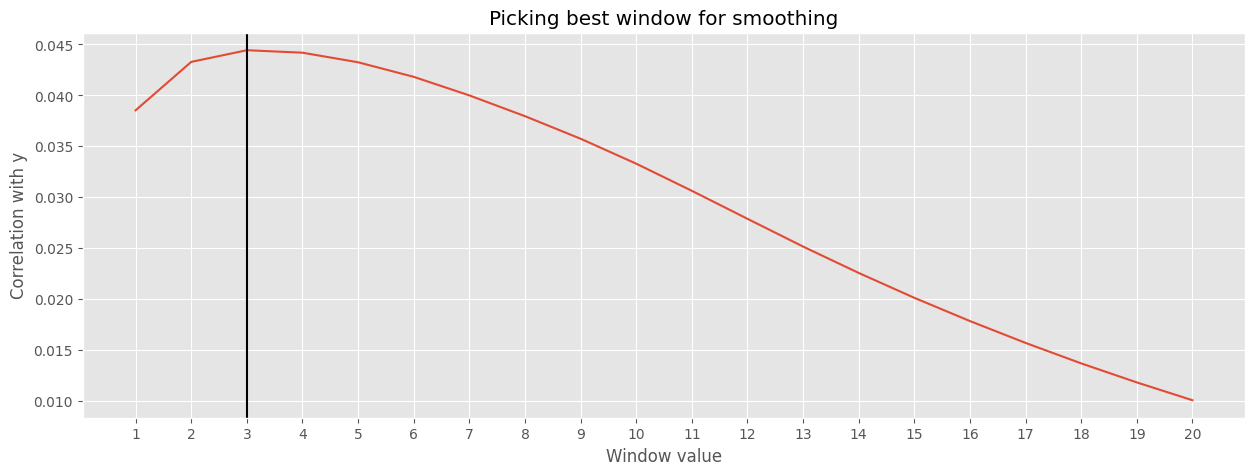

In [6]:
def select_window(data, plot=False):
    values = data['values']
    label = data['label']
    
    smooth_corr = pd.Series()
    win_range = range(1, 21)
    
    for win_value in win_range:      
        smoothed = (values
                    .rolling(win_value, 1)
                    .mean())
        
        smooth_corr.loc[win_value] = abs(smoothed.corr(label))
        
    best_win = smooth_corr.sort_values(ascending=False).index[0]
    
    if plot:
        print('Best window value:', best_win)
        
        sns.lineplot(smooth_corr)
        
        plt.xticks(win_range)
        plt.axvline(best_win, color='black')
        
        plt.xlabel('Window value')
        plt.ylabel('Correlation with y')
        plt.title('Picking best window for smoothing')
        
        plt.show()
    
    return int(best_win)


best_win = select_window(re_train, plot=True)

Что ж, корреляция значений и целевого признака довольно слабая, но все равно будет лучше, если мы ее хоть немного повысим.

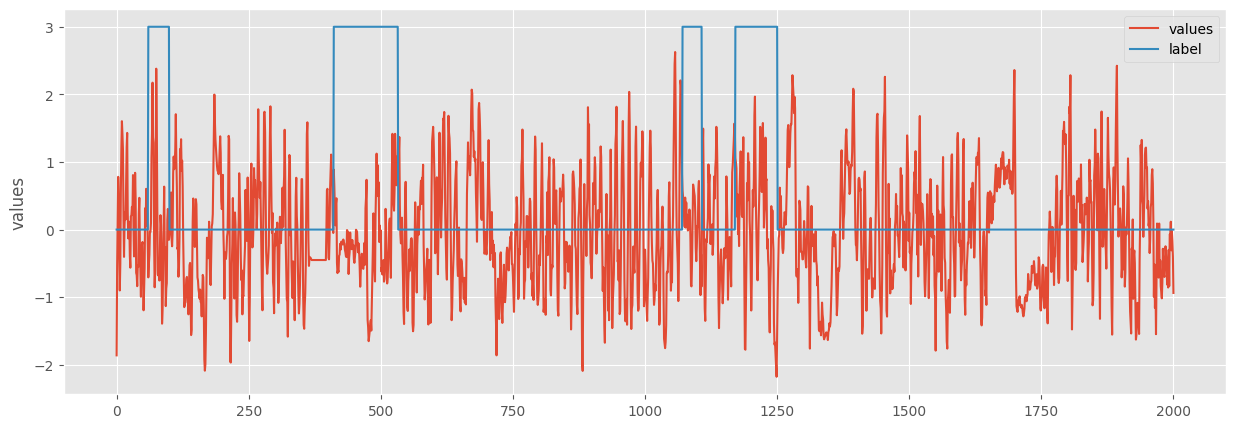

In [7]:
smoothe_data = lambda X, win: X.rolling(win, 1).mean()
re_train['values'] = smoothe_data(re_train['values'], best_win)

sns.lineplot(re_train.loc[:2000, 'values'], label='values')
sns.lineplot(re_train.loc[:2000, 'label']*3, label='label')

plt.show()

И действительно, кривая значений стала немного "мягче" и понятнее. На первый взгляд, в наших временных рядах нет ни тренда, ни сезонности, но будет лучше, если мы все-таки проверим это с помощью теста Дики-Фуллера на стационарность. Причем лучше проверять не весь ряд целиком, а по каждому объекту, помеченному идентификатором.

In [9]:
def get_stationarity(data):
    train_ids = data['id'].unique()
    st_list = []

    print('Objects tested:')
    for i, obj in enumerate(train_ids):
        try:
            adfuller_result = adfuller(
                data[data['id'] == obj]['values']
            )
        except ValueError:
            continue
        
        stat = adfuller_result[0]
        pv = adfuller_result[4]['5%']
        
        if stat > pv:
            st_list.append(0)
        else:
            st_list.append(1)
        
        stdout.write(f"\r{i+1}")
        stdout.flush()
        sleep(0.00001)
    print('\n')
    
    st_df = pd.DataFrame({
        'id': train_ids, 
        'stationarity': st_list
    })

    return st_df


st_df = get_stationarity(re_train)
st_coef = st_df['stationarity'].sum() / st_df.shape[0]

print('Stationarity coefficient:', st_coef)

re_train = re_train.merge(st_df, on='id', how='left')

re_train

Objects tested:
79912

Stationarity coefficient: 0.23089148062869155


,id,values,label,year,month,quarter,dayofweek,stationarity
0,19114,-1.860000,0.0,2016,1,1,4,0
1,19114,-0.535000,0.0,2016,2,1,0,0
2,19114,0.110000,0.0,2016,3,1,1,0
3,19114,0.780000,0.0,2016,4,2,4,0
4,19114,0.516667,0.0,2016,5,2,6,0
...,...,...,...,...,...,...,...,...
5047002,98870,-0.086650,1.0,2019,11,4,4,0
5047003,98870,0.556683,1.0,2019,12,4,6,0
5047004,98870,-0.023317,1.0,2020,1,1,2,0
5047005,98870,-0.619984,1.0,2020,2,1,5,0


Если доля стационарных рядов составляет меньше трети от всех, то в большинстве рядов все-таки присутствует тренд и/или сезонность. Перед следующим этапом анализа нужно разделить выборку на тренировочную и валидационную. Для этого необходимо узнать, насколько классы сбалансированы.

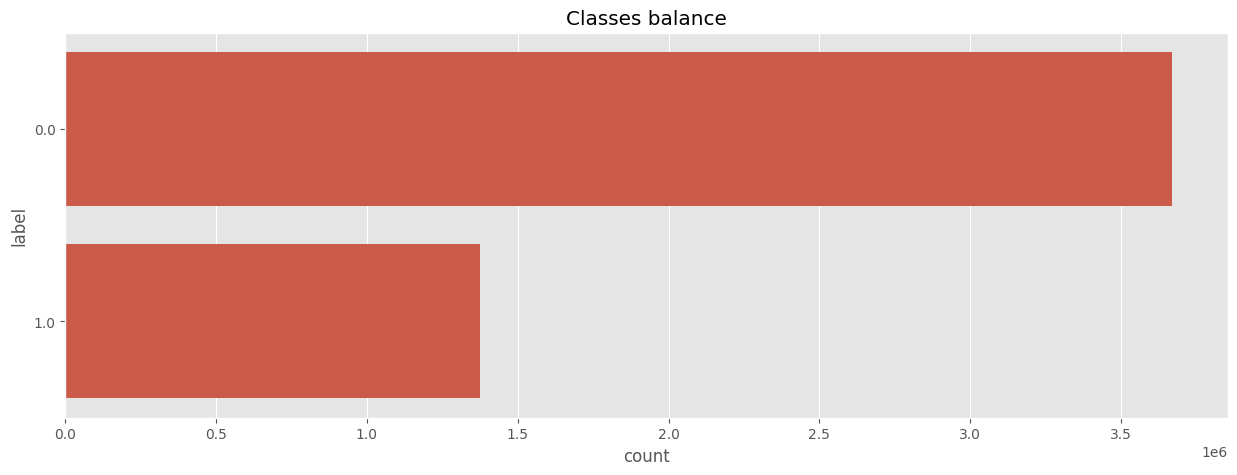

In [10]:
labels_cnt = re_train['label'].value_counts()

sns.barplot(labels_cnt, orient='h')

plt.title('Classes balance')
plt.show()

Классы явно несбалансированы, поэтому при разделении данных выборки нужно стратифицировать.

In [11]:
y = re_train.pop('label')

X_train, X_valid, y_train, y_valid = train_test_split(
    re_train, y, 
    test_size=0.2, 
    random_state=33, 
    stratify=y
)

data_pool = X_train, X_valid, y_train, y_valid

X_train

,id,values,year,month,quarter,dayofweek,stationarity
966982,98689,-0.430000,2019,11,4,4,0
3901842,72027,0.563333,2018,4,2,6,0
418366,67553,-0.630000,2018,6,2,4,0
4031223,46134,0.610000,2018,11,4,3,0
3273996,28254,-1.543333,2018,12,4,5,0
...,...,...,...,...,...,...,...
2615822,70856,-0.470000,2018,4,2,6,0
1954925,98497,0.113333,2020,2,1,5,0
1190473,28315,-1.446667,2018,3,1,3,0
3334500,43432,-1.496667,2023,2,1,2,0


Давайте оценим важность признаков. Я это буду делать тремя способами - корреляция с целевой переменной и F-тест для классификации. Примем 2 гипотезы, **нулевая** - тот или иной признак не влияет на класс, **ненулевая** - признак влияет на класс. 

Но перед этим я уберу признак идентификатора из всех данных и сохраню их в переменные, так как они нам потом понадобятся. 

In [12]:
X_train_ids = X_train.pop('id')
X_valid_ids = X_valid.pop('id')
re_test_ids = re_test.pop('id')

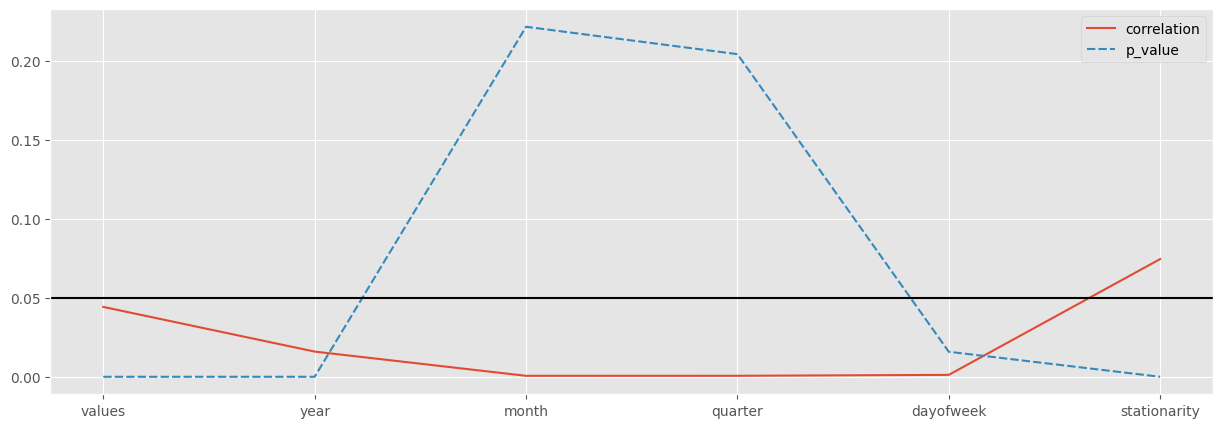

In [13]:
stat_df = pd.DataFrame({
    'correlation': X_train.corrwith(y_train).abs(), 
    'p_value': f_classif(X_train, y_train)[1]
})

sns.lineplot(stat_df)

plt.axhline(0.05, color='black')
plt.show()

Корреляция всех признаков с классами очень низкая, что означает, что данные скорее случайны. А вот F-тест показал, что имеют значение признаки месяца и квартала, в которые проводились наблюдения, в отличие от признака значений, который практически равен нулю. 

# ML

In [14]:
def calc_rocauc(model, X, y):
    proba = model.predict_proba(X)[:, 1]
    rocauc = roc_auc_score(y, proba)
    
    return round(rocauc, 2)


def estimate_model(model, pool=data_pool):
    X_train, X_valid, y_train, y_valid = pool
    model.fit(X_train, y_train)

    rocauc_train = calc_rocauc(model, X_train, y_train)
    rocauc_valid = calc_rocauc(model, X_valid, y_valid)

    print('Train ROC AUC: ', rocauc_train)
    print('Valid ROC AUC: ', rocauc_valid)
    
    
baseline = LogisticRegression()

estimate_model(baseline)

Train ROC AUC:  0.54
Valid ROC AUC:  0.54


In [15]:
cat = CatBoostClassifier(
        eval_metric='AUC', 
        allow_writing_files=False, 
        random_state=33
)

cat.fit(X_train, 
        y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], 
        early_stopping_rounds=10, 
        verbose=10)

rocauc_train = calc_rocauc(cat, X_train, y_train)
rocauc_valid = calc_rocauc(cat, X_valid, y_valid)

print('Train ROC AUC: ', rocauc_train)
print('Valid ROC AUC: ', rocauc_valid)

Learning rate set to 0.246389
0:	test: 0.5677648	test1: 0.5681110	best: 0.5681110 (0)	total: 625ms	remaining: 10m 24s
10:	test: 0.5749450	test1: 0.5751260	best: 0.5751260 (10)	total: 6.21s	remaining: 9m 18s
20:	test: 0.5757603	test1: 0.5758393	best: 0.5758393 (20)	total: 12.7s	remaining: 9m 52s
30:	test: 0.5760628	test1: 0.5760923	best: 0.5760923 (30)	total: 18.7s	remaining: 9m 43s
40:	test: 0.5762344	test1: 0.5761920	best: 0.5761920 (40)	total: 24.3s	remaining: 9m 27s
50:	test: 0.5763656	test1: 0.5762389	best: 0.5762389 (50)	total: 30s	remaining: 9m 18s
60:	test: 0.5764766	test1: 0.5762980	best: 0.5762980 (60)	total: 35.6s	remaining: 9m 7s
70:	test: 0.5766960	test1: 0.5764747	best: 0.5764747 (70)	total: 41.4s	remaining: 9m 1s
80:	test: 0.5768333	test1: 0.5764973	best: 0.5765012 (79)	total: 47.4s	remaining: 8m 57s
90:	test: 0.5770404	test1: 0.5766310	best: 0.5766318 (87)	total: 53.5s	remaining: 8m 54s
100:	test: 0.5772722	test1: 0.5767529	best: 0.5767570 (96)	total: 59.6s	remaining: 8m

In [16]:
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric='auc', early_stopping_rounds=10)
xgb.fit(X_train, 
        y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=10)

rocauc_train = calc_rocauc(xgb, X_train, y_train)
rocauc_valid = calc_rocauc(xgb, X_valid, y_valid)

print('Train ROC AUC: ', rocauc_train)
print('Valid ROC AUC: ', rocauc_valid)

[0]	validation_0-auc:0.57286	validation_1-auc:0.57264
[10]	validation_0-auc:0.57660	validation_1-auc:0.57612
[20]	validation_0-auc:0.57768	validation_1-auc:0.57658
[30]	validation_0-auc:0.57836	validation_1-auc:0.57662
[37]	validation_0-auc:0.57869	validation_1-auc:0.57659
Train ROC AUC:  0.58
Valid ROC AUC:  0.58
